In [1]:
# CPI FNAB Forecasting with ARIMA (Python Version)

## Summary:

### Forecast Malaysia’s CPI (Food & Non-Alcoholic Beverages) from Jan 2010–Aug 2023.
### Combines ARIMA(1,1,2) and lag-based regression model with backward selection.
### Produces 24-month forecast and compares results.

In [2]:
# 1. Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [3]:
# 2. Load Data
df = pd.read_excel("cpi_fnab.xlsx")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
ts = df['fnab']

In [4]:
# 3. Stationarity Test 
def adf_test(x): return adfuller(x, autolag='AIC')[1]
def kpss_test(x): return kpss(x, regression='c')[1]

print("ADF p (level):", adf_test(ts))
print("KPSS p (level):", kpss_test(ts))
print("ADF p (1st diff):", adf_test(ts.diff().dropna()))
print("KPSS p (1st diff):", kpss_test(ts.diff().dropna()))

ADF p (level): 0.9866783339066243
KPSS p (level): 0.01
ADF p (1st diff): 0.01397884516314601
KPSS p (1st diff): 0.1


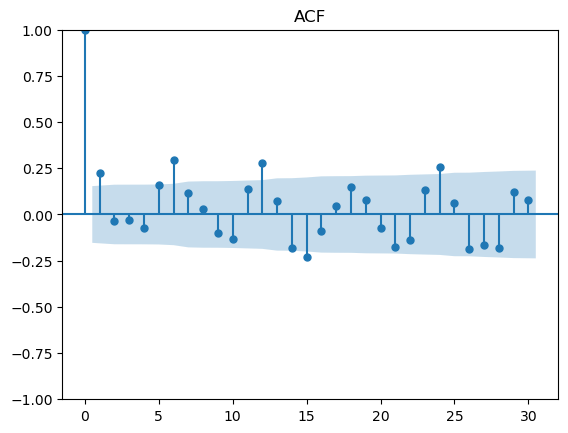

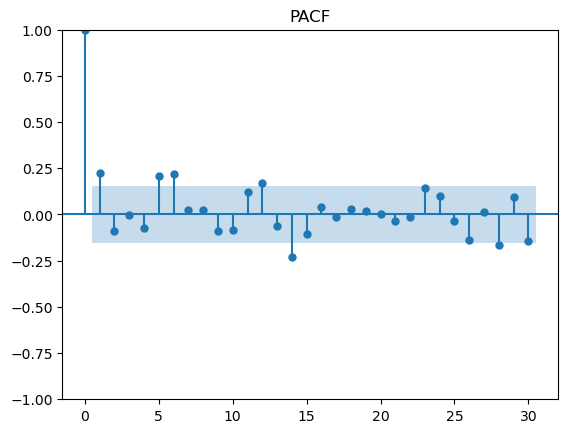

In [5]:
# 4. ACF/PACF 
plot_acf(ts.diff().dropna(), lags=30); plt.title("ACF"); plt.show()
plot_pacf(ts.diff().dropna(), lags=30); plt.title("PACF"); plt.show()

In [6]:
# 5. Fit ARIMA Models 
orders = [(3,1,2), (3,1,1), (2,1,2), (2,1,1), (1,1,2)]
results = {order: ARIMA(ts, order=order).fit() for order in orders}

In [7]:
# 6. Compare AIC/BIC 
for order, model in results.items():
    print(f"ARIMA{order} -> AIC: {model.aic:.2f}, BIC: {model.bic:.2f}")

ARIMA(3, 1, 2) -> AIC: 211.08, BIC: 229.64
ARIMA(3, 1, 1) -> AIC: 208.75, BIC: 224.22
ARIMA(2, 1, 2) -> AIC: 208.72, BIC: 224.19
ARIMA(2, 1, 1) -> AIC: 208.56, BIC: 220.93
ARIMA(1, 1, 2) -> AIC: 207.34, BIC: 219.71


In [8]:
# 7. Forecast with Best Model (ARIMA(1,1,2)) 
best_model = results[(1,1,2)]
forecast_arima = best_model.get_forecast(steps=24)
forecast_ci = forecast_arima.conf_int()
future_dates = pd.date_range(ts.index[-1] + pd.offsets.MonthBegin(), periods=24, freq='MS')

In [9]:
# Backward Stepwise Regression on Lagged CPI

In [10]:
# 1. Create Lagged Features 
def create_lags(series, max_lag):
    df = pd.DataFrame({'y': series})
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = series.shift(lag)
    return df.dropna()

def backward_stepwise(X, y, threshold_out=0.05):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    while True:
        pvals = model.pvalues.drop('const')
        if pvals.max() < threshold_out:
            break
        worst = pvals.idxmax()
        X = X.drop(columns=worst)
        model = sm.OLS(y, X).fit()
    return model

lag_df = create_lags(ts, max_lag=12)
X, y = lag_df.drop(columns='y'), lag_df['y']
reg_model = backward_stepwise(X, y)
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.514e+04
Date:                Fri, 18 Jul 2025   Prob (F-statistic):          5.92e-218
Time:                        00:10:34   Log-Likelihood:                -88.157
No. Observations:                 152   AIC:                             186.3
Df Residuals:                     147   BIC:                             201.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1632      0.338      0.482      0.6

In [11]:
# 2. Forecast with Regression Model 
selected_lags = [int(col.split('_')[1]) for col in reg_model.model.exog_names if col.startswith('lag_')]
history = ts.tolist()
reg_preds = []

for _ in range(24):
    lag_inputs = [history[-lag] for lag in selected_lags]
    row = [1] + lag_inputs  # const + lag values
    pred = np.dot(row, reg_model.params)
    reg_preds.append(pred)
    history.append(pred)

In [12]:
# Compare Forecasts

In [13]:
# 1. Value Forecast Comparison 
future_dates = pd.date_range(ts.index[-1] + pd.offsets.MonthBegin(), periods=24, freq='MS')

comparison_df = pd.DataFrame({
    'Date': future_dates,
    'ARIMA Forecast': forecast_arima.predicted_mean.values,
    'Regression Forecast': reg_preds
}).set_index('Date')

print("\nFirst 12-Month Forecast Comparison:")
print(comparison_df.head(12).round(2))


First 12-Month Forecast Comparison:
            ARIMA Forecast  Regression Forecast
Date                                           
2023-09-01          152.84               152.75
2023-10-01          153.16               153.03
2023-11-01          153.49               153.40
2023-12-01          153.81               153.77
2024-01-01          154.13               154.14
2024-02-01          154.46               154.41
2024-03-01          154.78               154.69
2024-04-01          155.10               155.02
2024-05-01          155.43               155.37
2024-06-01          155.75               155.74
2024-07-01          156.08               156.09
2024-08-01          156.40               156.41


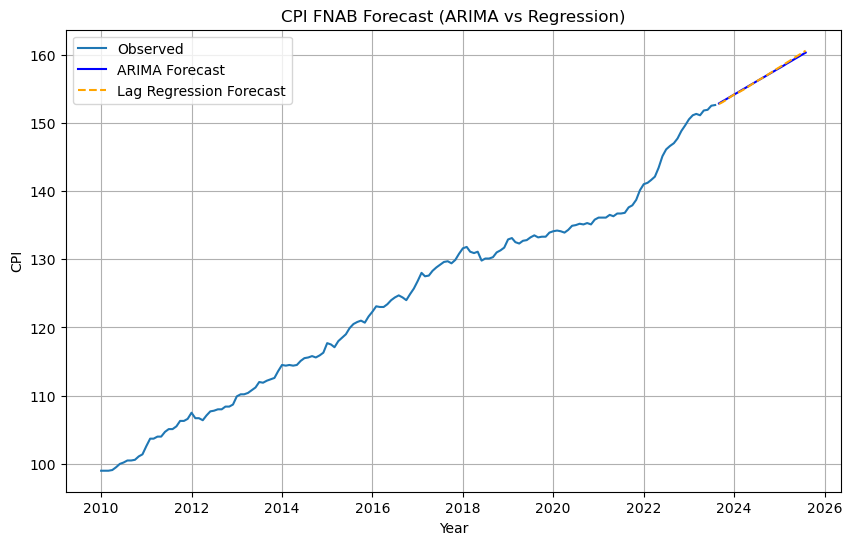

In [14]:
# 2. Plot Forecast Comparison 
plt.figure(figsize=(10,6))
plt.plot(ts, label='Observed')
plt.plot(comparison_df.index, comparison_df['ARIMA Forecast'], label='ARIMA Forecast', color='blue')
plt.plot(comparison_df.index, comparison_df['Regression Forecast'], label='Lag Regression Forecast', color='orange', linestyle='--')
plt.title('CPI FNAB Forecast (ARIMA vs Regression)')
plt.xlabel('Year')
plt.ylabel('CPI')
plt.grid(True)
plt.legend()
plt.show()

In [15]:
# 3. Error Spread 
comparison_df['Abs Diff'] = abs(comparison_df['ARIMA Forecast'] - comparison_df['Regression Forecast'])
print("\nAverage Absolute Difference:", round(comparison_df['Abs Diff'].mean(), 2))


Average Absolute Difference: 0.1


In [16]:
# 4. Actual CPI values from Sep 2023 to Aug 2024
actual_cpi = [
    152.8, 153.0, 152.6, 153.0,
    153.5, 153.9, 153.9, 154.1,
    154.5, 154.9, 155.0, 155.1
]

actual_index = pd.date_range(start="2023-09-01", periods=12, freq='MS')

actual_df = pd.DataFrame({
    'Actual CPI': actual_cpi,
    'ARIMA Forecast': comparison_df.loc[actual_index, 'ARIMA Forecast'].values,
    'Regression Forecast': comparison_df.loc[actual_index, 'Regression Forecast'].values
}, index=actual_index)

In [17]:
# 4. ARIMA error vs actual
arima_mape = mean_absolute_percentage_error(actual_df['Actual CPI'], actual_df['ARIMA Forecast']) * 100
arima_rmse = mean_squared_error(actual_df['Actual CPI'], actual_df['ARIMA Forecast'], squared=False)

In [18]:
# 5. Regression error vs actual
reg_mape = mean_absolute_percentage_error(actual_df['Actual CPI'], actual_df['Regression Forecast']) * 100
reg_rmse = mean_squared_error(actual_df['Actual CPI'], actual_df['Regression Forecast'], squared=False)

print("Forecast Evaluation Against Actuals (Sep 2023 – Aug 2024):\n")
print(f"ARIMA MAPE: {arima_mape:.2f}%, RMSE: {arima_rmse:.4f}")
print(f"Regression MAPE: {reg_mape:.2f}%, RMSE: {reg_rmse:.4f}")

Forecast Evaluation Against Actuals (Sep 2023 – Aug 2024):

ARIMA MAPE: 0.49%, RMSE: 0.8368
Regression MAPE: 0.47%, RMSE: 0.8028


In [19]:
# 6. Add Absolute % Error Columns 
actual_df['ARIMA % Error'] = abs((actual_df['Actual CPI'] - actual_df['ARIMA Forecast']) / actual_df['Actual CPI']) * 100
actual_df['Regression % Error'] = abs((actual_df['Actual CPI'] - actual_df['Regression Forecast']) / actual_df['Actual CPI']) * 100

print("\nActual vs Forecasted CPI with % Errors:")
print(actual_df.round(2))


Actual vs Forecasted CPI with % Errors:
            Actual CPI  ARIMA Forecast  Regression Forecast  ARIMA % Error  \
2023-09-01       152.8          152.84               152.75           0.02   
2023-10-01       153.0          153.16               153.03           0.11   
2023-11-01       152.6          153.49               153.40           0.58   
2023-12-01       153.0          153.81               153.77           0.53   
2024-01-01       153.5          154.13               154.14           0.41   
2024-02-01       153.9          154.46               154.41           0.36   
2024-03-01       153.9          154.78               154.69           0.57   
2024-04-01       154.1          155.10               155.02           0.65   
2024-05-01       154.5          155.43               155.37           0.60   
2024-06-01       154.9          155.75               155.74           0.55   
2024-07-01       155.0          156.08               156.09           0.69   
2024-08-01       155.1 

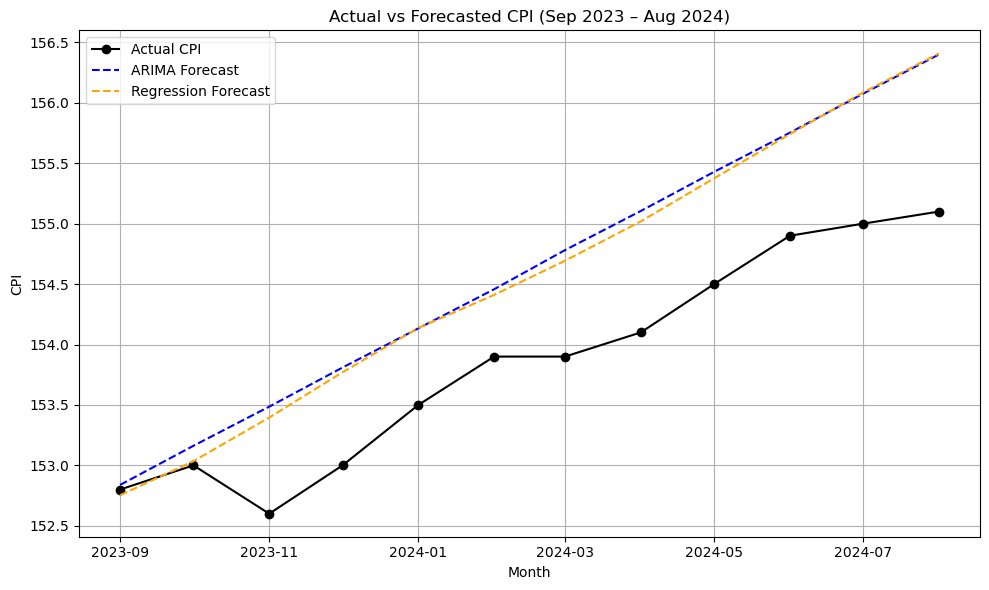

In [20]:
# 7. Plot Actual vs Forecasts 
plt.figure(figsize=(10,6))
plt.plot(actual_df.index, actual_df['Actual CPI'], label='Actual CPI', color='black', marker='o')
plt.plot(actual_df.index, actual_df['ARIMA Forecast'], label='ARIMA Forecast', color='blue', linestyle='--')
plt.plot(actual_df.index, actual_df['Regression Forecast'], label='Regression Forecast', color='orange', linestyle='--')
plt.title('Actual vs Forecasted CPI (Sep 2023 – Aug 2024)')
plt.xlabel('Month')
plt.ylabel('CPI')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()